Load library

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [4]:
data = pd.read_csv("/Users/sylvainestebe/Code/DataSci-AU-24-1/data/bikes.csv")


load training, validation and test set

In [5]:
performances = []
train = pd.read_csv(f'/Users/sylvainestebe/Code/DataSci-AU-24-1/data/train.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/DataSci-AU-24-1/data/val.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/DataSci-AU-24-1/data/test.csv', index_col=0)

In [6]:
X_train, y_train = train.iloc[:,:14], train.iloc[:,15]
X_val, y_val = val.iloc[:,:14], val.iloc[:,15]
X_test, y_test = test.iloc[:,:14], test.iloc[:,15]

Decorator in python. What does theses functions?

In [7]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

In [8]:
@run_on_splits
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

# Random Forest

## Questions
 - What is `GridSearchCV` doing?
        - What is the difference between `RandomizedSearchCV` and `GridSearchCV`?
        - **Bonus question**: Given that we do have a validation set, could we do model selection without using cross-validation? Which parameter in 
        GridSearchCV` or `RandomizedSearchCV` would you have to change, and how, to do so?

In [9]:
rfreg = RandomForestRegressor(random_state=42) # first, we instantiate the estimator

In [10]:
param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.3, 0.6, 0.9], # can you guess what this is, without looking at the documentation?
    'ccp_alpha': [0.01, 0.1, 1.0]
}

In [11]:
cv_rfr = RandomizedSearchCV(estimator=rfreg, # I am choosing RandomizedSearchCV for speed, but you can also go for GridSearchCV :)
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=20, # this should more likely be above 100, and in general the higher the better
                            cv=5)
cv_rfr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'ccp_alpha': [0.01, 0.1, 1.0],
                                        'max_depth': [2, 3, 5, 10],
                                        'max_features': [0.3, 0.6, 0.9],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 100, 200,
                                                         500]},
                   scoring='neg_mean_squared_error')

In [12]:
cv_rfr.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.01,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 0.9,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [13]:
evaluate(model=cv_rfr.best_estimator_, model_name=f'random-forest')

In [14]:
importances = cv_rfr.best_estimator_.feature_importances_


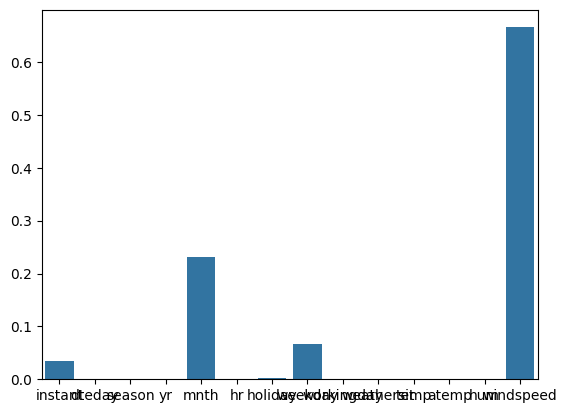

In [16]:
# the above computes the (normalized) total reduction of the criterion brought by that feature.
sns.barplot(x=train.columns.tolist()[:14], y=importances, color=sns.color_palette()[0])
plt.show()